# Plug flow reactor simulation of Thruster

![caption](Graphics/thruster-details.png)


In [1]:
import cantera as ct
import numpy as np

from matplotlib import pyplot as plt
import csv
import pandas as pd

In [2]:
# input file containing the surface reaction mechanism
cti_file = '../RMG-model/cantera/chem_annotated.cti'

cti_file = '../RMG-model/cantera/chem0050.cti'

gas=ct.Solution(cti_file)
surf = ct.Interface(cti_file,'surface1', [gas])

In [3]:
gas()


  gas:

       temperature             300  K
          pressure          101325  Pa
           density         0.81974  kg/m^3
  mean mol. weight         20.1797  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          1905.6        3.845e+04     J
   internal energy      -1.217e+05       -2.456e+06     J
           entropy          7257.7        1.465e+05     J/K
    Gibbs function     -2.1754e+06        -4.39e+07     J
 heat capacity c_p          1030.1        2.079e+04     J/K
 heat capacity c_v          618.03        1.247e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                Ne              1                1         -17.5994
     [  +38 minor]              0                0



In [4]:
print(", ".join(gas.species_names))

Ne, H4N2O2(2), NH2OH(3), HNO3(4), CH3OH(5), H2O(6), N2(7), O2(8), CO2(9), H2(10), CO(11), C2H6(12), CH2O(13), CH3(14), C3H8(15), H(16), C2H5(17), HCO(18), CH3CHO(19), OH(20), C2H4(21), CH4(24), HO2(36), NH2(82), HONO(91), NO2(92), HNOH(94), N2H3(99), H3N2O(193), H2NO2(195), S(196), H2NO3(244), H2NO3(245), H2N2O(381), H2N2O(382), NNDO(385), NNO(394), S(429), S(489)


In [5]:
print(", ".join(surf.species_names))

X(1), HX(22), OX(23), CH3X(25), HOX(26), H2OX(27), CO2X(28), OCX(29), CX(30), CH2X(31), CHX(32), H2NX(211), SX(214), H2NOX(216), H3NOX(217), HNO3X(220), CH3OX(222), CH4OX(223)




This example solves a plug flow reactor problem, with coupled surface and gas chemistry.





In [6]:
# unit conversion factors to SI
cm = 0.01 # m
minute = 60.0  # s

In [7]:
#######################################################################
# Input Parameters for combustor
#######################################################################
mass_flow_rate =  0.5e-3 # kg/s
temperature_c = 400.0  # Initial Temperature in Celsius
pressure = ct.one_atm # constant

length = 1.1 * cm  # Catalyst bed length. 11mm
cross_section_area = np.pi * (0.9*cm)**2  # Catalyst bed area.  18mm diameter circle.

### Catalyst properties. Some are hard to estimate
# if we can, update this lit value or verify the value richard calculated
cat_specific_area = 140 # m2/g
cat_density = 2 / cm**3 # 2 g/m3
print(f"Catalyst density {cat_density :.2e} g/m3")
cat_area_per_vol = cat_specific_area * cat_density  # m2/m3
cat_area_per_vol # m2/m3
print(f"Catalyst area per volume {cat_area_per_vol :.2e} m2/m3")
print()

porosity = 0.38  # Catalyst bed porosity (0.38)
# Al2O3 particles are about 0.7mm diameter

Catalyst density 2.00e+06 g/m3
Catalyst area per volume 2.80e+08 m2/m3



In [8]:
output_filename = 'surf_pfr_output.csv'

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 2001
dt = 1.0

#####################################################################

temperature_kelvin = temperature_c + 273.15  # convert to Kelvin

# import the gas model and set the initial conditions
gas = ct.Solution(cti_file, 'gas')

# should this be mole fractions or mole fractions?
gas.TPY = temperature_kelvin, pressure, 'H4N2O2(2):0.14, NH2OH(3):0.3, HNO3(4):0.3, CH3OH(5):0.16, H2O(6):0.04'

# import the surface model
surf = ct.Interface(cti_file,'surface1', [gas])
surf.TP = temperature_kelvin, pressure

r_len = length/(NReactors-1) 
r_vol = cross_section_area * r_len * porosity # gas volume

outfile = open(output_filename,'w')
writer = csv.writer(outfile)
writer.writerow(['Distance (mm)', 'T (C)', 'P (atm)'] +
                gas.species_names + surf.species_names + ['alpha'])

# catalyst area in one reactor
cat_area = cat_area_per_vol * r_vol

# Not sure we need the velocity
velocity = mass_flow_rate / (gas.density * cross_section_area)

In [9]:
def report_rates(n=8):
    print("\nHighest net rates of progress, gas")
    for i in np.argsort(abs(gas.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.net_rates_of_progress[i]:8.1g}")
    print("\nHighest net rates of progress, surface")
    for i in np.argsort(abs(surf.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.net_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, gas")
    for i in np.argsort(abs(gas.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, surface")
    for i in np.argsort(abs(surf.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, gas")
    for i in np.argsort(abs(gas.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, surface")
    for i in np.argsort(abs(surf.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.reverse_rates_of_progress[i]:8.1g}")

    print(f"\nSurface rates have been scaled by surface/volume ratio {cat_area_per_vol:.1e} m2/m3")
    print("So are on a similar basis of volume of reactor (though porosity not yet accounted for)")
    print(" kmol / m3 / s")
report_rates()


Highest net rates of progress, gas
 41 : H3N2O(193) + OH(20) <=> H4N2O2(2)                   -7e+06
 40 : H3N2O(193) + OH(20) <=> H4N2O2(2)                   -7e+06
 82 : HO2(36) + N2H3(99) <=> H4N2O2(2)                    -1e+02
138 : H2NO3(244) + S(196) <=> H4N2O2(2) + HNO3(4)           -0.3
122 : H2NO3(244) + S(196) <=> H4N2O2(2) + HNO3(4)           -0.3
139 : NO2(92) + OH(20) (+M) <=> HNO3(4) (+M)              -0.002
 84 : H(16) + S(196) <=> H4N2O2(2)                        -1e-05

Highest net rates of progress, surface
  0 : H2O(6) + X(1) <=> H2OX(27)                           8e+07
  1 : NH2OH(3) + X(1) <=> H3NOX(217)                       3e+07
  3 : CH3OH(5) + X(1) <=> CH4OX(223)                       2e+07
  2 : HNO3(4) + X(1) <=> HNO3X(220)                        1e+07
  4 : H4N2O2(2) + X(1) <=> SX(214)                         6e+06
 10 : NH2OH(3) + 2 X(1) <=> H2NOX(216) + HX(22)            4e+03
 15 : CH3OH(5) + 2 X(1) <=> CH3OX(222) + HX(22)            3e+03

Highest forwa

In [10]:
def report_rate_constants(n=8):
    print("\nHighest forward rate constants, gas")
    for i in np.argsort(abs(gas.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}")
    print("\nHighest forward rate constants, surface")
    for i in np.argsort(abs(surf.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, gas")
    for i in np.argsort(abs(gas.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, surface")
    for i in np.argsort(abs(surf.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rate_constants[i]:8.1e}")

    print("Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction.")
report_rate_constants()


Highest forward rate constants, gas
135 : H2NO3(244) + HCO(18) <=> CH2O(13) + HNO3(4)        3.6e+11
127 : H2NO3(244) + HCO(18) <=> CH2O(13) + HNO3(4)        3.6e+11
102 : H2NO3(245) + HCO(18) <=> CH2O(13) + HNO3(4)        1.8e+11
154 : C2H5(17) + NO2(92) <=> C2H4(21) + HONO(91)         1.4e+11
 27 : HCO(18) + OH(20) <=> CO(11) + H2O(6)               1.1e+11
 15 : H(16) + HCO(18) <=> CO(11) + H2(10)                1.1e+11
 10 : C2H5(17) + H(16) (+M) <=> C2H6(12) (+M)            9.1e+10

Highest forward rate constants, surface
 28 : CHX(32) + HX(22) <=> CH2X(31) + X(1)               3.1e+21
 27 : CH2X(31) + HX(22) <=> CH3X(25) + X(1)              3.1e+21
 29 : CHX(32) + X(1) <=> CX(30) + HX(22)                 3.1e+21
 13 : HX(22) + OX(23) <=> HOX(26) + X(1)                 1.7e+19
 24 : CX(30) + OX(23) <=> OCX(29) + X(1)                 3.7e+18
 26 : CO2X(28) + HX(22) <=> HOX(26) + OCX(29)            2.2e+17
 21 : CH4(24) + HOX(26) + X(1) <=> CH3X(25) + H2OX(27)   4.7e+16

Highest rev

In [11]:
# The plug flow reactor is represented by a linear chain of zero-dimensional
# reactors. The gas at the inlet to the first one has the specified inlet
# composition, and for all others the inlet composition is fixed at the
# composition of the reactor immediately upstream. Since in a PFR model there
# is no diffusion, the upstream reactors are not affected by any downstream
# reactors, and therefore the problem may be solved by simply marching from
# the first to last reactor, integrating each one to steady state.

TDY = gas.TDY
cov = surf.coverages

# create a new reactor
gas.TDY = TDY
r = ct.IdealGasReactor(gas, energy='off')
r.volume = r_vol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas, name='downstream')

# Add the reacting surface to the reactor. The area is set to the desired
# catalyst area in the reactor.
rsurf = ct.ReactorSurface(surf, r, A=cat_area)

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r, downstream, master=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 24

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-12
sim.atol = 1.0e-21

sim.verbose = False

print('    distance(mm)     H4N2O2(2)   NH2OH(3)   HNO3(4)  CH3OH(5)  alpha')
for n in range(NReactors):
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = TDY = r.thermo.TDY
    gas.TP = temperature_kelvin, pressure # fix it to be constant again!
    upstream.syncState()
    sim.reinitialize()
    try:
        # the default is residual_threshold = sim.rtol*10
        sim.advance_to_steady_state(residual_threshold = sim.rtol*1000)
    except ct.CanteraError:
        t = sim.time
        sim.set_initial_time(0)
        gas.TDY = TDY
        r.syncState()
        sim.reinitialize()
        print(f"Couldn't reach {t:.1g} s so going to {0.1*t:.1g} s")
        sim.advance(0.1*t)
        report_rates()
        report_rate_constants()
 
    dist = n * r_len * 1.0e3   # distance in mm
        
    gasHeat = np.dot(gas.net_rates_of_progress, gas.delta_enthalpy) # heat evolved by gas phase reaction
    surfHeat = np.dot(surf.net_rates_of_progress, surf.delta_enthalpy) # heat evolved by surf phase reaction 
    alpha = gasHeat/surfHeat #ratio of gas heat evolved to surface heat evolved.

    if not n % 10:
        print('    {:10f}  {:10f}  {:10f}  {:10f} {:10f}  {:5.1e}'.format(dist, *gas['H4N2O2(2)','NH2OH(3)','HNO3(4)','CH3OH(5)'].X, alpha ))

    # write the gas mole fractions and surface coverages vs. distance
    writer.writerow([dist, r.T - 273.15, r.thermo.P/ct.one_atm] +
                    list(gas.X) + list(surf.coverages) + [alpha])
    
    #report_rates()
    #report_rate_constants()

outfile.close()
print("Results saved to '{0}'".format(output_filename))

    distance(mm)     H4N2O2(2)   NH2OH(3)   HNO3(4)  CH3OH(5)  alpha
      0.000000    0.000017    0.322039    0.188208   0.197698  4.3e+16
Couldn't reach 2e+15 s so going to 2e+14 s

Highest net rates of progress, gas
 80 : H3N2O(193) + HNOH(94) <=> NH2OH(3) + NNDO(385)           9
167 : HNOH(94) + NNO(394) <=> H3N2O(193) + NH2OH(3)            6
192 : H3N2O(193) + HNOH(94) <=> H2N2O(382) + NH2OH(3)          2
117 : H3N2O(193) + S(489) <=> NNDO(385) + S(429)             0.7
194 : H3N2O(193) + S(489) <=> H2N2O(382) + S(429)           -0.7
152 : HNOH(94) + HONO(91) <=> NH2OH(3) + NO2(92)             0.2
190 : 2 H3N2O(193) <=> H2N2O(382) + NNO(394)                 0.1

Highest net rates of progress, surface
  9 : OH(20) + X(1) <=> HOX(26)                            1e-09
  0 : H2O(6) + X(1) <=> H2OX(27)                          -5e-10
 14 : H2OX(27) + OX(23) <=> 2 HOX(26)                     -5e-10
 12 : O2(8) + 2 X(1) <=> 2 OX(23)                         -2e-10
 13 : HX(22) + OX(23) <=> 

      2.255000    0.000000    0.357279    0.188073   0.197685  1.4e+17
      2.310000    0.000000    0.357359    0.188071   0.197684  1.4e+17
      2.365000    0.000000    0.357435    0.188069   0.197684  1.3e+17
      2.420000    0.000000    0.357508    0.188067   0.197683  1.3e+17
      2.475000    0.000000    0.357578    0.188065   0.197683  1.2e+17
      2.530000    0.000000    0.357644    0.188063   0.197683  1.2e+17
      2.585000    0.000000    0.357707    0.188062   0.197682  1.1e+17
      2.640000    0.000000    0.357767    0.188060   0.197682  1.1e+17
      2.695000    0.000000    0.357824    0.188058   0.197682  1.0e+17
      2.750000    0.000000    0.357879    0.188056   0.197681  1.0e+17
      2.805000    0.000000    0.357932    0.188054   0.197681  9.7e+16
      2.860000    0.000000    0.357982    0.188052   0.197681  9.3e+16
      2.915000    0.000000    0.358030    0.188051   0.197680  9.0e+16
      2.970000    0.000000    0.358076    0.188049   0.197680  8.7e+16
      

      4.565000    0.000000    0.358844    0.188001   0.197670  6.7e+16
      4.620000    0.000000    0.358858    0.187999   0.197670  6.5e+16
      4.675000    0.000000    0.358871    0.187998   0.197670  6.4e+16
      4.730000    0.000000    0.358884    0.187996   0.197669  6.3e+16
      4.785000    0.000000    0.358897    0.187995   0.197669  6.1e+16
      4.840000    0.000000    0.358909    0.187993   0.197669  6.0e+16
      4.895000    0.000000    0.358921    0.187992   0.197668  5.9e+16
      4.950000    0.000000    0.358932    0.187990   0.197668  5.7e+16
      5.005000    0.000000    0.358943    0.187989   0.197668  5.6e+16
      5.060000    0.000000    0.358953    0.187987   0.197667  5.5e+16
      5.115000    0.000000    0.358963    0.187986   0.197667  5.4e+16
      5.170000    0.000000    0.358973    0.187984   0.197667  5.3e+16
      5.225000    0.000000    0.358983    0.187983   0.197666  5.2e+16
      5.280000    0.000000    0.358992    0.187981   0.197666  5.1e+16
      

      9.845000    0.000000    0.359190    0.187872   0.197639  2.0e+16
      9.900000    0.000000    0.359189    0.187871   0.197639  2.0e+16
      9.955000    0.000000    0.359189    0.187870   0.197638  1.9e+16
     10.010000    0.000000    0.359189    0.187869   0.197638  1.9e+16
     10.065000    0.000000    0.359188    0.187868   0.197638  1.9e+16
     10.120000    0.000000    0.359188    0.187866   0.197637  1.9e+16
     10.175000    0.000000    0.359187    0.187865   0.197637  1.8e+16
     10.230000    0.000000    0.359187    0.187864   0.197637  1.8e+16
     10.285000    0.000000    0.359186    0.187863   0.197636  1.8e+16
     10.340000    0.000000    0.359186    0.187862   0.197636  1.8e+16
     10.395000    0.000000    0.359185    0.187861   0.197636  1.8e+16
     10.450000    0.000000    0.359184    0.187860   0.197635  1.8e+16
     10.505000    0.000000    0.359184    0.187858   0.197635  1.7e+16
     10.560000    0.000000    0.359183    0.187857   0.197635  1.7e+16
     1

In [12]:
sim.time

232753567488210.72

In [13]:
gas.TDY = TDY
r.syncState()
r.thermo.T

673.15

In [14]:
r.thermo.X - gas.X

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [15]:
rsurf.kinetics.net_rates_of_progress

array([-6.86644785e-17,  8.15524661e-18,  8.96741452e-18,  3.58788679e-18,
        9.77826970e-29,  9.90900281e-28,  4.35563325e-21,  7.56792268e-35,
       -8.29520602e-29,  5.65762259e-19,  1.67426759e-24,  7.03601751e-18,
       -1.41633545e-19,  4.36156027e-21, -2.84997678e-19,  3.30777311e-26,
        7.17775283e-25, -1.16866554e-17, -4.00707038e-22,  2.28767448e-53,
        6.36964464e-42,  1.78857513e-48, -2.08308337e-34,  2.04634570e-34,
        7.93684356e-37,  2.08306027e-34, -2.29950824e-39,  1.21649070e-38,
        8.57759972e-39,  7.94083741e-37,  3.98208862e-40])

In [16]:
surf.net_rates_of_progress

array([-6.86644785e-17,  8.15524661e-18,  8.96741452e-18,  3.58788679e-18,
        9.77826970e-29,  9.90900281e-28,  4.35563325e-21,  7.56792268e-35,
       -8.29520602e-29,  5.65762259e-19,  1.67426759e-24,  7.03601751e-18,
       -1.41633545e-19,  4.36156027e-21, -2.84997678e-19,  3.30777311e-26,
        7.17775283e-25, -1.16866554e-17, -4.00707038e-22,  2.28767448e-53,
        6.36964464e-42,  1.78857513e-48, -2.08308337e-34,  2.04634570e-34,
        7.93684356e-37,  2.08306027e-34, -2.29950824e-39,  1.21649070e-38,
        8.57759972e-39,  7.94083741e-37,  3.98208862e-40])

In [17]:
gas.TDY

(673.15,
 0.673531560942224,
 array([1.24269577e-32, 2.21570339e-15, 3.18882168e-01, 3.18162711e-01,
        1.70212766e-01, 8.12830450e-02, 1.66374488e-31, 7.58516120e-07,
        7.62165538e-27, 7.01172158e-10, 5.89623540e-24, 3.59026658e-30,
        6.98372768e-24, 2.01518300e-18, 1.89425402e-31, 1.86427759e-13,
        1.15460147e-35, 9.61028680e-28, 4.38058116e-33, 1.69903973e-09,
        5.52397380e-31, 1.03447141e-33, 8.40129741e-10, 3.44427890e-05,
        1.12575173e-03, 2.21345417e-05, 4.63092442e-05, 1.42966522e-05,
        7.50010586e-06, 2.69992926e-15, 6.61000489e-16, 1.65739898e-12,
        2.49405286e-10, 3.74387993e-15, 1.15369862e-02, 8.27927377e-02,
        4.34371605e-03, 2.42747548e-12, 1.15346725e-02]))

In [18]:
r.thermo.TDY

(673.15,
 0.673531560942224,
 array([1.24269577e-32, 2.21570339e-15, 3.18882168e-01, 3.18162711e-01,
        1.70212766e-01, 8.12830450e-02, 1.66374488e-31, 7.58516120e-07,
        7.62165538e-27, 7.01172158e-10, 5.89623540e-24, 3.59026658e-30,
        6.98372768e-24, 2.01518300e-18, 1.89425402e-31, 1.86427759e-13,
        1.15460147e-35, 9.61028680e-28, 4.38058116e-33, 1.69903973e-09,
        5.52397380e-31, 1.03447141e-33, 8.40129741e-10, 3.44427890e-05,
        1.12575173e-03, 2.21345417e-05, 4.63092442e-05, 1.42966522e-05,
        7.50010586e-06, 2.69992926e-15, 6.61000489e-16, 1.65739898e-12,
        2.49405286e-10, 3.74387993e-15, 1.15369862e-02, 8.27927377e-02,
        4.34371605e-03, 2.42747548e-12, 1.15346725e-02]))

In [19]:
report_rate_constants()


Highest forward rate constants, gas
135 : H2NO3(244) + HCO(18) <=> CH2O(13) + HNO3(4)        3.6e+11
127 : H2NO3(244) + HCO(18) <=> CH2O(13) + HNO3(4)        3.6e+11
102 : H2NO3(245) + HCO(18) <=> CH2O(13) + HNO3(4)        1.8e+11
154 : C2H5(17) + NO2(92) <=> C2H4(21) + HONO(91)         1.4e+11
 27 : HCO(18) + OH(20) <=> CO(11) + H2O(6)               1.1e+11
 15 : H(16) + HCO(18) <=> CO(11) + H2(10)                1.1e+11
 10 : C2H5(17) + H(16) (+M) <=> C2H6(12) (+M)            9.9e+10

Highest forward rate constants, surface
 28 : CHX(32) + HX(22) <=> CH2X(31) + X(1)               3.1e+21
 27 : CH2X(31) + HX(22) <=> CH3X(25) + X(1)              3.1e+21
 29 : CHX(32) + X(1) <=> CX(30) + HX(22)                 3.1e+21
 13 : HX(22) + OX(23) <=> HOX(26) + X(1)                 1.7e+19
 24 : CX(30) + OX(23) <=> OCX(29) + X(1)                 3.7e+18
 26 : CO2X(28) + HX(22) <=> HOX(26) + OCX(29)            2.2e+17
 21 : CH4(24) + HOX(26) + X(1) <=> CH3X(25) + H2OX(27)   4.7e+16

Highest rev

In [20]:
sim.verbose


False

In [21]:
sim.component_name(40)

'IdealGasReactor_1: S(429)'

In [22]:
gas.species_index('S(429)')

37

<BarContainer object of 197 artists>

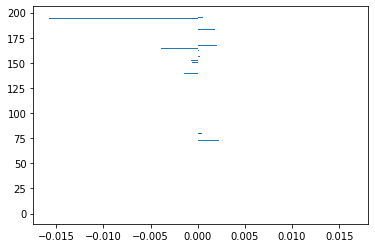

In [23]:
plt.barh(np.arange(len(gas.net_rates_of_progress)),gas.net_rates_of_progress)

In [24]:
gas.T

673.15

In [25]:
gas.T

673.15

In [26]:
data = pd.read_csv(output_filename)
data

,Distance (mm),T (C),P (atm),Ne,H4N2O2(2),NH2OH(3),HNO3(4),CH3OH(5),H2O(6),N2(7),...,CX(30),CH2X(31),CHX(32),H2NX(211),SX(214),H2NOX(216),H3NOX(217),HNO3X(220),CH3OX(222),CH4OX(223)
0.0000,400.0,1.0,8.578141e-37,1.667055e-05,0.322039,0.188208,0.197698,0.164727,4.138491e-37,6.021276e-07,...,1.452166e-41,7.852777e-38,5.964571e-09,1.507122e-17,1.975025e-07,9.579797e-13,7.039680e-13,0.226700,1.826960e-14,4.301300e+16
0.0055,400.0,1.0,8.535662e-37,2.244074e-08,0.325517,0.188203,0.197707,0.167501,4.140152e-37,7.481719e-07,...,-7.620857e-42,-9.151270e-37,3.605983e-08,4.892301e-19,4.323618e-06,2.335070e-11,1.697530e-11,0.226700,4.405816e-13,5.676306e+15
0.0110,400.0,1.0,-4.696225e-34,3.019205e-10,0.327541,0.188198,0.197707,0.167620,4.140140e-37,8.207731e-07,...,1.540599e-47,2.041798e-33,9.658569e-07,1.479647e-19,9.142262e-05,5.281783e-10,3.815893e-10,0.226700,9.904091e-12,1.371930e+15
0.0165,400.0,1.0,8.092795e-321,7.427165e-12,0.328572,0.188196,0.197706,0.167626,4.140132e-37,8.543776e-07,...,-2.367565e-47,-4.327785e-33,1.880168e-08,6.356665e-23,1.545217e-06,9.253084e-12,6.663954e-12,0.975412,1.729635e-13,5.442611e+17
0.0220,400.0,1.0,5.535076e-89,7.693693e-13,0.329251,0.188195,0.197706,0.167627,4.140128e-37,8.689935e-07,...,1.476948e-55,1.164287e-51,7.481888e-09,2.441991e-24,5.604975e-07,3.438639e-12,2.471339e-12,0.993543,6.414415e-14,4.429057e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.9780,400.0,1.0,2.291067e-32,1.290832e-15,0.359178,0.187849,0.197632,0.167859,2.209567e-31,8.818975e-07,...,1.823909e-40,1.468487e-34,5.512563e-06,1.038933e-26,2.527514e-09,9.512130e-12,6.255212e-12,0.997416,1.625936e-13,1.594187e+16
10.9835,400.0,1.0,2.291066e-32,1.289593e-15,0.359178,0.187849,0.197632,0.167860,2.209567e-31,8.818978e-07,...,-2.403797e-40,-2.666217e-35,5.512568e-06,1.036981e-26,2.522234e-09,9.503365e-12,6.249446e-12,0.997416,1.624437e-13,1.594011e+16
10.9890,400.0,1.0,2.291066e-32,1.288357e-15,0.359178,0.187848,0.197632,0.167860,2.209567e-31,8.818980e-07,...,-2.644528e-40,-8.167962e-34,5.512574e-06,1.035033e-26,2.516971e-09,9.494616e-12,6.243690e-12,0.997416,1.622942e-13,1.593756e+16
10.9945,400.0,1.0,2.291065e-32,1.287124e-15,0.359178,0.187848,0.197632,0.167860,2.209566e-31,8.818982e-07,...,2.676281e-40,-6.484364e-36,5.512580e-06,1.033091e-26,2.511724e-09,9.485883e-12,6.237945e-12,0.997416,1.621449e-13,1.593753e+16


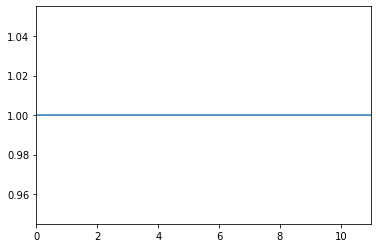

In [27]:
data['T (C)'].plot()

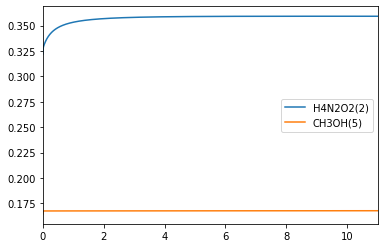

In [28]:
data[['H4N2O2(2)', 'CH3OH(5)']].plot()

In [29]:
list(data.columns)[:4]

['Distance (mm)', 'T (C)', 'P (atm)', 'Ne']

In [30]:
specs = list(data.columns)
specs = specs[4:]
specs

['H4N2O2(2)',
 'NH2OH(3)',
 'HNO3(4)',
 'CH3OH(5)',
 'H2O(6)',
 'N2(7)',
 'O2(8)',
 'CO2(9)',
 'H2(10)',
 'CO(11)',
 'C2H6(12)',
 'CH2O(13)',
 'CH3(14)',
 'C3H8(15)',
 'H(16)',
 'C2H5(17)',
 'HCO(18)',
 'CH3CHO(19)',
 'OH(20)',
 'C2H4(21)',
 'CH4(24)',
 'HO2(36)',
 'NH2(82)',
 'HONO(91)',
 'NO2(92)',
 'HNOH(94)',
 'N2H3(99)',
 'H3N2O(193)',
 'H2NO2(195)',
 'S(196)',
 'H2NO3(244)',
 'H2NO3(245)',
 'H2N2O(381)',
 'H2N2O(382)',
 'NNDO(385)',
 'NNO(394)',
 'S(429)',
 'S(489)',
 'X(1)',
 'HX(22)',
 'OX(23)',
 'CH3X(25)',
 'HOX(26)',
 'H2OX(27)',
 'CO2X(28)',
 'OCX(29)',
 'CX(30)',
 'CH2X(31)',
 'CHX(32)',
 'H2NX(211)',
 'SX(214)',
 'H2NOX(216)',
 'H3NOX(217)',
 'HNO3X(220)',
 'CH3OX(222)',
 'CH4OX(223)']

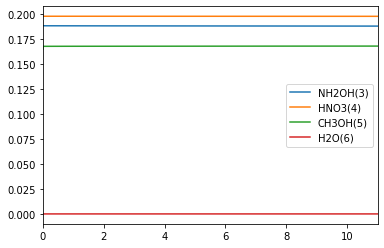

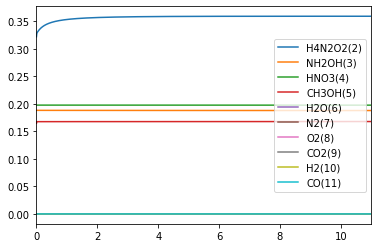

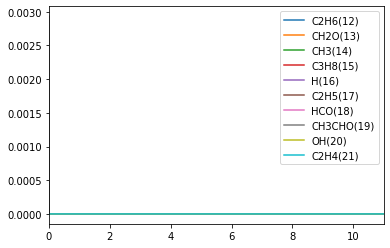

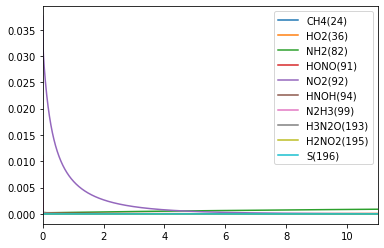

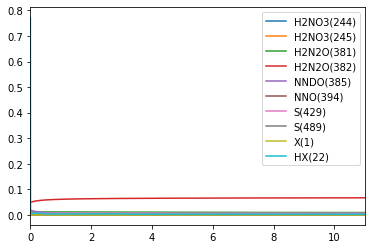

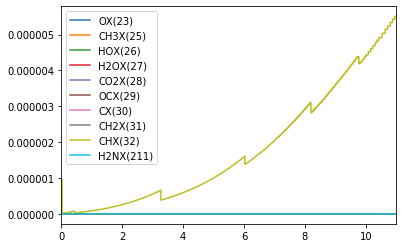

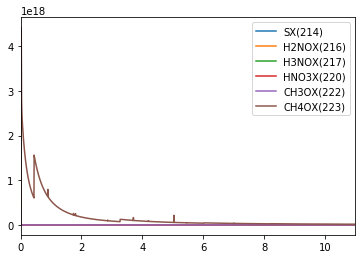

In [31]:
data[specs[1:5]].plot()

for i in range(0,len(specs),10):
    data[specs[i:i+10]].plot()

In [32]:
gas.species('NO(49)').composition

IndexError: map::at:  key not found

In [ ]:
data['NO(49)'].plot()

In [ ]:
(data[specs].max()>0.01)

In [ ]:
data.loc[0]